<a href="https://colab.research.google.com/github/miracle65536/XAIentists/blob/ModelBuildingPratibha/Copy_of_ModelBuilding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

<div class="markdown-google-sans">
  <h2>Explore the Gemini API</h2>
  <p>The Gemini API gives you access to Gemini models created by Google DeepMind. Gemini models are built from the ground up to be multimodal, so you can reason seamlessly across text, images, code, and audio.
  </p>
  <strong>How to get started</strong>
    <ol>
      <li>Go to <a href="https://aistudio.google.com/">Google AI Studio</a> and log in with your Google account.</li>
      <li><a href="https://aistudio.google.com/app/apikey">Create an API key</a>.</li>
      <li>Use a quickstart for <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Prompting.ipynb">Python</a>, or call the REST API using <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb">curl</a>.</li>
      </ol>
  <strong>Explore use cases</strong>
    <ul>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Market_a_Jet_Backpack.ipynb">Create a marketing campaign</a></li>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Audio.ipynb">Analyze audio recordings</a></li>
      <li><a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/System_instructions.ipynb">Use System instructions in chat</a></li>
    </ul>
  <p>To learn more, check out the <a href="https://github.com/google-gemini/cookbook">Gemini cookbook</a> or visit the <a href="https://ai.google.dev/docs/">Gemini API documentation</a>.
  </p>
</div>


In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('/content/compas-scores-two-years-processed.csv')
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,is_recid,r_charge_degree,r_days_from_arrest,r_charge_desc,is_violent_recid,vr_charge_degree,vr_charge_desc,c_length_of_stay,r_length_of_stay,custody_length_of_stay,two_year_recid
0,Male,Greater than 45,Other,0,0,0,0,F,0.003327,0,NaN,NaN,NaN,0,NaN,NaN,0.98,NaN,7.0,0
1,Male,25 - 45,African-American,0,0,0,0,F,0.006376,1,(F3),0.0,0.005186,1,(F3),0.046398,10.08,8.0,10.0,1
2,Male,Less than 25,African-American,0,0,1,4,F,0.065706,1,(M1),0.0,0.006626,0,NaN,NaN,1.09,0.0,0.0,1
3,Male,Less than 25,African-American,0,1,0,1,F,0.010535,0,NaN,NaN,NaN,0,NaN,NaN,1.28,NaN,2.0,0
4,Male,25 - 45,Other,0,0,0,2,F,0.158442,0,NaN,NaN,NaN,0,NaN,NaN,1.28,NaN,2.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sex                     7214 non-null   object 
 1   age_cat                 7214 non-null   object 
 2   race                    7214 non-null   object 
 3   juv_fel_count           7214 non-null   int64  
 4   juv_misd_count          7214 non-null   int64  
 5   juv_other_count         7214 non-null   int64  
 6   priors_count            7214 non-null   int64  
 7   c_charge_degree         7214 non-null   object 
 8   c_charge_desc           7214 non-null   float64
 9   is_recid                7214 non-null   int64  
 10  r_charge_degree         3471 non-null   object 
 11  r_days_from_arrest      3471 non-null   float64
 12  r_charge_desc           3471 non-null   float64
 13  is_violent_recid        7214 non-null   int64  
 14  vr_charge_degree        819 non-null    

In [ ]:
df.shape

(7214, 20)

In [ ]:
df1=pd.read_csv('/content/df3 (1).csv')
df1.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,c_charge_desc_embedding,r_charge_desc_embedding,vr_charge_desc_embedding
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,2014-07-07,2014-07-14,0,0,327,0,0,[-8.43500853e-01 -2.02844843e-01 -3.70449871e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-01-26,2013-02-05,0,9,159,1,1,[-8.06700647e-01 3.98664968e-03 -7.22263336e-...,[-7.47953653e-01 -1.29772410e-01 -4.52372640e-...,[-7.47953653e-01 -1.29772410e-01 -4.52372640e-...
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,2013-06-16,2013-06-16,4,0,63,0,1,[-5.64117730e-01 -2.06362948e-01 -8.81924450e-...,[-4.18367565e-01 3.77063937e-02 -9.08996642e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaN,NaN,1,0,1174,0,0,[-3.93119633e-01 2.45940998e-01 -7.81277895e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,NaN,NaN,2,0,1102,0,0,[-4.82077599e-01 -6.46965727e-02 -3.43196660e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        7214 non-null   int64  
 1   name                      7214 non-null   object 
 2   first                     7214 non-null   object 
 3   last                      7214 non-null   object 
 4   compas_screening_date     7214 non-null   object 
 5   sex                       7214 non-null   object 
 6   dob                       7214 non-null   object 
 7   age                       7214 non-null   int64  
 8   age_cat                   7214 non-null   object 
 9   race                      7214 non-null   object 
 10  juv_fel_count             7214 non-null   int64  
 11  decile_score              7214 non-null   int64  
 12  juv_misd_count            7214 non-null   int64  
 13  juv_other_count           7214 non-null   int64  
 14  priors_c

In [ ]:
df1.shape

(7214, 56)

In [ ]:
# Combining 'c_charge_desc_embedding', 'r_charge_desc_embedding', 'vr_charge_desc_embedding' columns from df1 to df

df = pd.merge(df, df1[['c_charge_desc_embedding', 'r_charge_desc_embedding', 'vr_charge_desc_embedding']], left_index=True, right_index=True, how='left')


In [ ]:
df.shape

(7214, 23)

In [ ]:
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,is_recid,...,is_violent_recid,vr_charge_degree,vr_charge_desc,c_length_of_stay,r_length_of_stay,custody_length_of_stay,two_year_recid,c_charge_desc_embedding,r_charge_desc_embedding,vr_charge_desc_embedding
0,Male,Greater than 45,Other,0,0,0,0,F,0.003327,0,...,0,NaN,NaN,0.98,NaN,7.0,0,[-8.43500853e-01 -2.02844843e-01 -3.70449871e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...
1,Male,25 - 45,African-American,0,0,0,0,F,0.006376,1,...,1,(F3),0.046398,10.08,8.0,10.0,1,[-8.06700647e-01 3.98664968e-03 -7.22263336e-...,[-7.47953653e-01 -1.29772410e-01 -4.52372640e-...,[-7.47953653e-01 -1.29772410e-01 -4.52372640e-...
2,Male,Less than 25,African-American,0,0,1,4,F,0.065706,1,...,0,NaN,NaN,1.09,0.0,0.0,1,[-5.64117730e-01 -2.06362948e-01 -8.81924450e-...,[-4.18367565e-01 3.77063937e-02 -9.08996642e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...
3,Male,Less than 25,African-American,0,1,0,1,F,0.010535,0,...,0,NaN,NaN,1.28,NaN,2.0,0,[-3.93119633e-01 2.45940998e-01 -7.81277895e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...
4,Male,25 - 45,Other,0,0,0,2,F,0.158442,0,...,0,NaN,NaN,1.28,NaN,2.0,0,[-4.82077599e-01 -6.46965727e-02 -3.43196660e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...,[-4.25018072e-02 3.68616432e-02 3.93935516e-...


In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
df.dtypes

,0
sex,object
age_cat,object
race,object
juv_fel_count,int64
juv_misd_count,int64
juv_other_count,int64
priors_count,int64
c_charge_degree,object
c_charge_desc,float64
is_recid,int64


In [ ]:
# Apply one-hot encoding to categorical columns, excluding columns with embeddings
categorical_cols = ['sex', 'race', 'age_cat', 'c_charge_desc', 'r_charge_desc', 'vr_charge_desc']
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# Drop columns with object dtype that are causing issues
object_cols = df_encoded.select_dtypes(include=['object']).columns
df_encoded = df_encoded.drop(columns=object_cols)

In [ ]:
df_encoded.head()

,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_recid,r_days_from_arrest,is_violent_recid,c_length_of_stay,r_length_of_stay,custody_length_of_stay,...,vr_charge_desc_0.017094017094017,vr_charge_desc_0.0207570207570207,vr_charge_desc_0.0256410256410256,vr_charge_desc_0.0293040293040293,vr_charge_desc_0.0341880341880341,vr_charge_desc_0.0378510378510378,vr_charge_desc_0.0415140415140415,vr_charge_desc_0.0451770451770451,vr_charge_desc_0.0463980463980464,vr_charge_desc_0.4017094017094017
0,0,0,0,0,0,NaN,0,0.98,NaN,7.0,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,0,1,0.0,1,10.08,8.0,10.0,...,False,False,False,False,False,False,False,False,True,False
2,0,0,1,4,1,0.0,0,1.09,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0,1,0,1,0,NaN,0,1.28,NaN,2.0,...,False,False,False,False,False,False,False,False,False,False
4,0,0,0,2,0,NaN,0,1.28,NaN,2.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
y = df_encoded['two_year_recid']         # target variable
X = df_encoded.drop(columns='two_year_recid')    # features

In [ ]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Initialize XGBClassifier
xgb = XGBClassifier(objective= 'binary:logistic', random_state = 0)

# Defining classifier parameters
cv_params = {'max_depth': [4,5,6],
              'min_child_weight' : [2,3,4],
              'learning_rate' : [0.1,0.2, 0.3],
              'n_estimators' : [50, 100]
            }

scoring =  {'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1'}

# Performing GridSearch
xgb_cv = GridSearchCV (xgb, cv_params, scoring = scoring, cv = 5, refit = 'f1')

# Record start time
start_time = time.time()

#Train the model
xgb_cv.fit(X_train, y_train)

# Record end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")

Training time: 97.94 seconds


In [ ]:
print("Best parameters:", xgb_cv.best_params_)
print("Best F1 score:", xgb_cv.best_score_)

Best parameters: {'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 50}
Best F1 score: 0.9658610931786775


In [ ]:
# Make predictions on the test set
y_pred = xgb_cv.best_estimator_.predict(X_test)

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1132   57]
 [   5  971]]


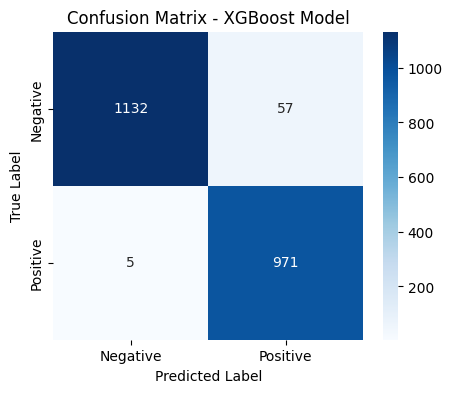

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost Model")
plt.show()